# Lecture 8: Options

## MIT 15.401 — Finance Theory I (Prof. Andrew Lo)

---

**Video:** [MIT OCW — Options](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/options/) (3 parts)

**Readings:** Brealey, Myers, and Allen — Chapters 20–21

---

Options are fundamentally different from forwards and futures. A forward contract **obligates** both sides to exchange. An option gives one side the **right, but not the obligation**, to trade. This asymmetry creates the characteristic **nonlinear** payoff that makes options so powerful — and so intellectually fascinating.

This session covers three big ideas:

1. **Payoff diagrams and strategies** — the visual language for understanding what options do, including protective puts, spreads, and straddles.

2. **Put-call parity** — a no-arbitrage relationship linking calls, puts, stocks, and bonds that requires no model at all.

3. **The binomial option-pricing model** (Cox, Ross, Rubinstein 1979) — a constructive proof that options can be priced by **replication**. The key insight: form a portfolio of stocks and bonds that exactly replicates the option payoff. The option must cost the same. The stunning implication: **the probability of the stock going up or down doesn't appear in the formula**.

## Table of Contents

1. [Definitions and Terminology](#1-definitions)
2. [Option Payoffs at Expiration](#2-payoffs)
3. [Option Strategies](#3-strategies)
4. [Put-Call Parity](#4-parity)
5. [Determinants of Option Value](#5-determinants)
6. [The Binomial Option-Pricing Model](#6-binomial)
7. [The Black-Scholes Formula](#7-black-scholes)
8. [A Brief History of Option-Pricing Theory](#8-history)
9. [Exercises](#9-exercises)

In [3]:
# ============================================================
# Setup
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from scipy.stats import norm
from scipy.optimize import brentq

plt.rcParams.update({
    'figure.figsize': (10, 5),
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'font.size': 12,
    'lines.linewidth': 2,
})

print("Libraries loaded successfully.")

Libraries loaded successfully.


---

<a id='1-definitions'></a>
## 1. Definitions and Terminology

### Two Types of Options

| | **Call Option** | **Put Option** |
|---|---|---|
| **Right to** | **Buy** the underlying at $K$ | **Sell** the underlying at $K$ |
| **Valuable when** | $S_T > K$ (price rises) | $S_T < K$ (price falls) |
| **Payoff** | $\max(S_T - K, 0)$ | $\max(K - S_T, 0)$ |

### Key Terms

| Term | Definition |
|------|-----------|
| **Underlying** | The asset the option is written on (stock, index, commodity, etc.) |
| **Strike price** $K$ | The price at which the option holder can buy/sell |
| **Expiration date** $T$ | The date the option expires |
| **Premium** | The price paid to acquire the option |
| **European** | Can only be exercised at expiration |
| **American** | Can be exercised at any time up to expiration |
| **In-the-money (ITM)** | Call: $S > K$; Put: $S < K$ (positive intrinsic value) |
| **At-the-money (ATM)** | $S \approx K$ |
| **Out-of-the-money (OTM)** | Call: $S < K$; Put: $S > K$ (zero intrinsic value) |

### Options as Insurance (Lo's Slide 4)

A **put option** is fundamentally like an **insurance policy**: you pay a premium upfront, and if bad things happen (price drops below $K$), you're protected. If nothing bad happens, you lose only the premium.

This is the key distinction from futures hedging (Session 7): futures eliminate **both** downside and upside. Options eliminate only the downside while preserving the upside — but you pay a premium for this asymmetry.

---

<a id='2-payoffs'></a>
## 2. Option Payoffs at Expiration

### Payoff Formulas

At expiration, the **payoff** depends only on the relationship between $S_T$ and $K$:

| Position | Payoff | Profit (net of premium) |
|----------|--------|---------|
| **Long call** | $\max(S_T - K, 0)$ | $\max(S_T - K, 0) - C$ |
| **Short call** | $-\max(S_T - K, 0)$ | $C - \max(S_T - K, 0)$ |
| **Long put** | $\max(K - S_T, 0)$ | $\max(K - S_T, 0) - P$ |
| **Short put** | $-\max(K - S_T, 0)$ | $P - \max(K - S_T, 0)$ |

### Lo's Payoff Table (Slide 9)

| | $S_T < K$ | $S_T = K$ | $S_T > K$ |
|---|---|---|---|
| **Call payoff** | 0 | 0 | $S_T - K$ |
| **Call profit** | $-C$ | $-C$ | $S_T - K - C$ |
| **Put payoff** | $K - S_T$ | 0 | 0 |
| **Put profit** | $K - S_T - P$ | $-P$ | $-P$ |

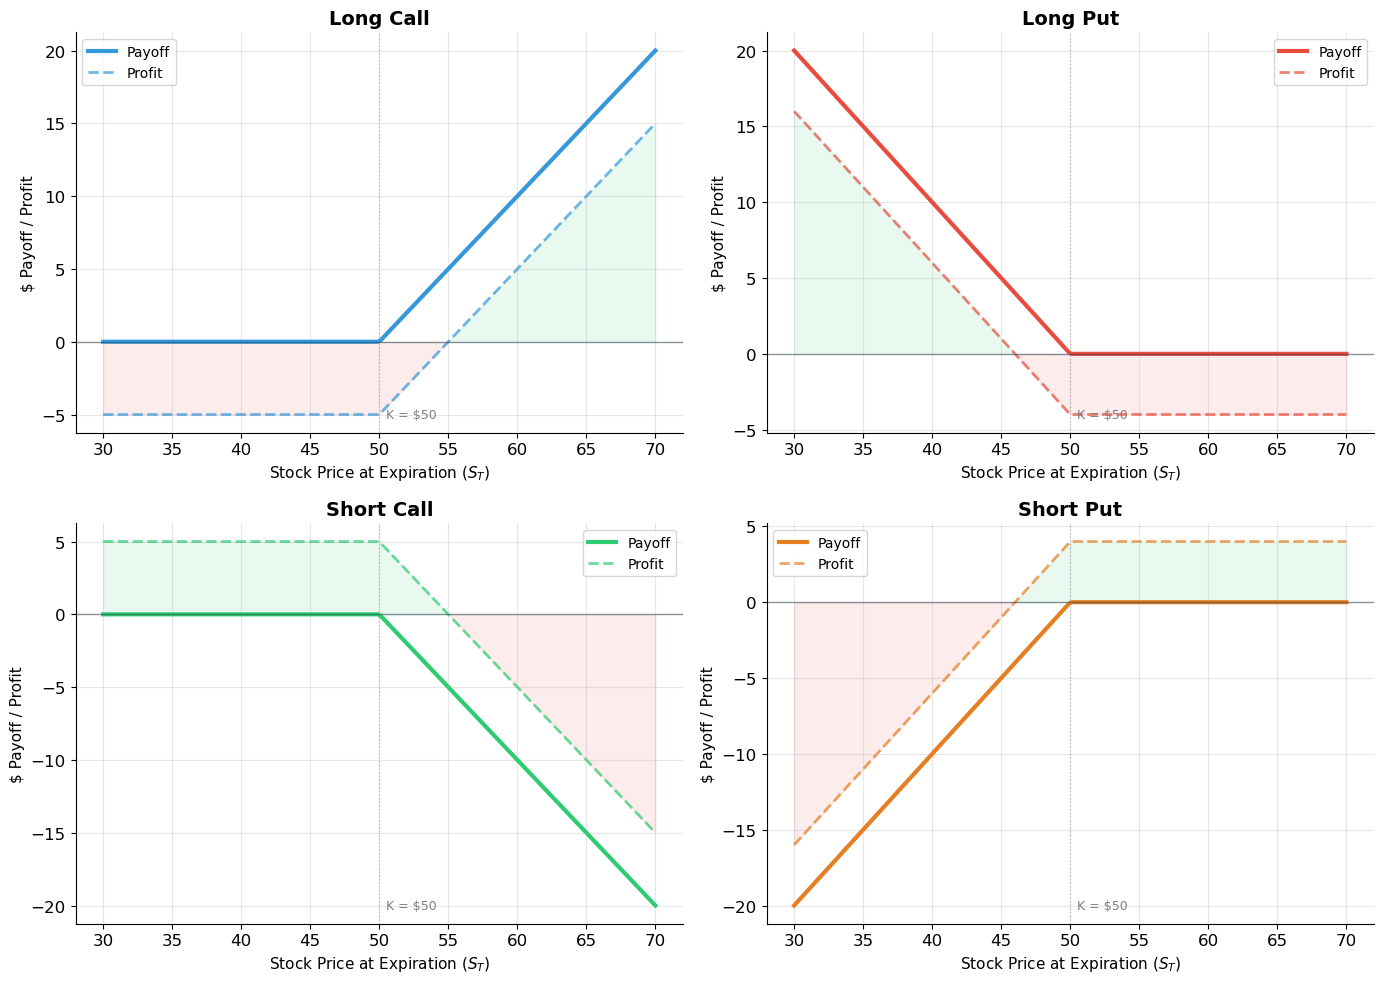

Key observations:
• Long call: unlimited upside, limited downside (lose at most the premium C)
• Long put:  limited upside (max K-P when S→0), limited downside (lose P)
• Short call: limited upside (earn C), UNLIMITED downside
• Short put:  limited upside (earn P), large downside (lose up to K-P)

• Long + Short payoffs sum to zero: options are zero-sum games


In [6]:
# ============================================================
# Four Basic Option Positions — Lo's Slide 8
# ============================================================
K = 50
S = np.linspace(30, 70, 200)

# Premium assumptions for profit diagrams
C = 5   # call premium
P = 4   # put premium

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
positions = [
    ('Long Call', np.maximum(S - K, 0), np.maximum(S - K, 0) - C, '#3498db'),
    ('Long Put', np.maximum(K - S, 0), np.maximum(K - S, 0) - P, '#e74c3c'),
    ('Short Call', -np.maximum(S - K, 0), C - np.maximum(S - K, 0), '#2ecc71'),
    ('Short Put', -np.maximum(K - S, 0), P - np.maximum(K - S, 0), '#e67e22'),
]

for ax, (title, payoff, profit, color) in zip(axes.flat, positions):
    ax.plot(S, payoff, color=color, linewidth=3, label='Payoff')
    ax.plot(S, profit, color=color, linewidth=2, linestyle='--', alpha=0.7, label='Profit')
    ax.axhline(y=0, color='#2c3e50', linewidth=1, alpha=0.5)
    ax.axvline(x=K, color='gray', linewidth=1, linestyle=':', alpha=0.4)
    ax.fill_between(S, 0, profit, where=profit > 0, alpha=0.1, color='#2ecc71')
    ax.fill_between(S, 0, profit, where=profit < 0, alpha=0.1, color='#e74c3c')
    ax.set_xlabel('Stock Price at Expiration ($S_T$)', fontsize=11)
    ax.set_ylabel('$ Payoff / Profit', fontsize=11)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.legend(fontsize=10)
    ax.text(K + 0.5, ax.get_ylim()[0] + 1, f'K = ${K}', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

print("Key observations:")
print("• Long call: unlimited upside, limited downside (lose at most the premium C)")
print("• Long put:  limited upside (max K-P when S→0), limited downside (lose P)")
print("• Short call: limited upside (earn C), UNLIMITED downside")
print("• Short put:  limited upside (earn P), large downside (lose up to K-P)")
print("\n• Long + Short payoffs sum to zero: options are zero-sum games")

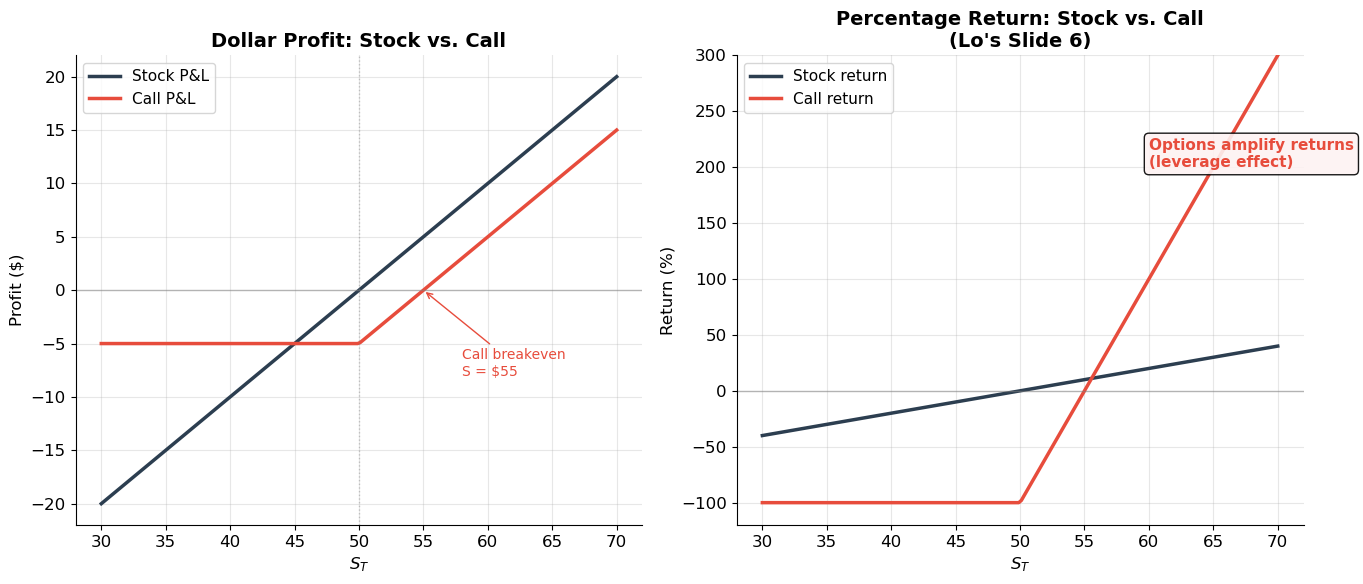

S_T = $40: Stock return = -20%,  Call return = -100%
S_T = $45: Stock return = -10%,  Call return = -100%
S_T = $50: Stock return = +0%,  Call return = -100%
S_T = $55: Stock return = +10%,  Call return = +0%
S_T = $60: Stock return = +20%,  Call return = +100%

The option magnifies gains AND losses — this is leverage in action.
Investment: stock costs $50, call costs only $5 (leverage = 10×)


In [7]:
# ============================================================
# Leverage Effect: Stock Return vs. Call Option Return (Lo's Slide 6)
# ============================================================
# ▶ MODIFY AND RE-RUN
S0 = 50       # current stock price
K = 50        # strike price
C = 5         # call premium
# ============================================================

S_T = np.linspace(30, 70, 200)
stock_return = (S_T - S0) / S0 * 100
option_payoff = np.maximum(S_T - K, 0)
option_return = (option_payoff - C) / C * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: Dollar payoffs
ax1.plot(S_T, S_T - S0, color='#2c3e50', linewidth=2.5, label='Stock P&L')
ax1.plot(S_T, option_payoff - C, color='#e74c3c', linewidth=2.5, label='Call P&L')
ax1.axhline(y=0, color='gray', linewidth=1, alpha=0.5)
ax1.axvline(x=K, color='gray', linewidth=1, linestyle=':', alpha=0.4)
ax1.set_xlabel('$S_T$', fontsize=12)
ax1.set_ylabel('Profit ($)', fontsize=12)
ax1.set_title('Dollar Profit: Stock vs. Call', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)

# Breakeven annotation
breakeven = K + C
ax1.annotate(f'Call breakeven\nS = ${breakeven}', xy=(breakeven, 0),
            xytext=(breakeven + 3, -8), fontsize=10, color='#e74c3c',
            arrowprops=dict(arrowstyle='->', color='#e74c3c'))

# Right: Percentage returns
ax2.plot(S_T, stock_return, color='#2c3e50', linewidth=2.5, label='Stock return')
ax2.plot(S_T, np.clip(option_return, -100, 300), color='#e74c3c', linewidth=2.5, label='Call return')
ax2.axhline(y=0, color='gray', linewidth=1, alpha=0.5)
ax2.set_xlabel('$S_T$', fontsize=12)
ax2.set_ylabel('Return (%)', fontsize=12)
ax2.set_title('Percentage Return: Stock vs. Call\n(Lo\'s Slide 6)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.set_ylim(-120, 300)

# Show leverage
ax2.annotate('Options amplify returns\n(leverage effect)', xy=(60, 200),
            fontsize=11, color='#e74c3c', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='#fdf2f2', alpha=0.9))

plt.tight_layout()
plt.show()

# Specific examples
for S_T_val in [40, 45, 50, 55, 60]:
    s_ret = (S_T_val - S0) / S0 * 100
    o_pf = max(S_T_val - K, 0)
    o_ret = (o_pf - C) / C * 100
    print(f"S_T = ${S_T_val}: Stock return = {s_ret:+.0f}%,  Call return = {o_ret:+.0f}%")

print("\nThe option magnifies gains AND losses — this is leverage in action.")
print(f"Investment: stock costs ${S0}, call costs only ${C} (leverage = {S0/C:.0f}×)")

---

<a id='3-strategies'></a>
## 3. Option Strategies

Options can be combined in various ways to create sophisticated payoff profiles. Lo presents three canonical strategies:

### Strategy 1: Protective Put (Stock + Put)

Buy a stock AND buy a put with strike $K$. This creates **downside protection** while preserving the upside — essentially portfolio insurance.

$$\text{Payoff} = S_T + \max(K - S_T, 0) = \max(S_T, K)$$

The portfolio can never be worth less than $K$.

### Strategy 2: Bull Call Spread (Buy Call₁, Sell Call₂)

Buy a call with low strike $K_1$ and sell a call with high strike $K_2 > K_1$. This bets on a **moderate** price increase.

$$\text{Payoff} = \max(S_T - K_1, 0) - \max(S_T - K_2, 0)$$

Maximum payoff is $K_2 - K_1$ (capped upside), but the net premium is lower than buying a call alone.

### Strategy 3: Straddle (Call + Put, same strike)

Buy a call AND a put with the **same strike** $K$. This bets on **volatility** — you profit if the stock moves significantly in **either direction**.

$$\text{Payoff} = \max(S_T - K, 0) + \max(K - S_T, 0) = |S_T - K|$$

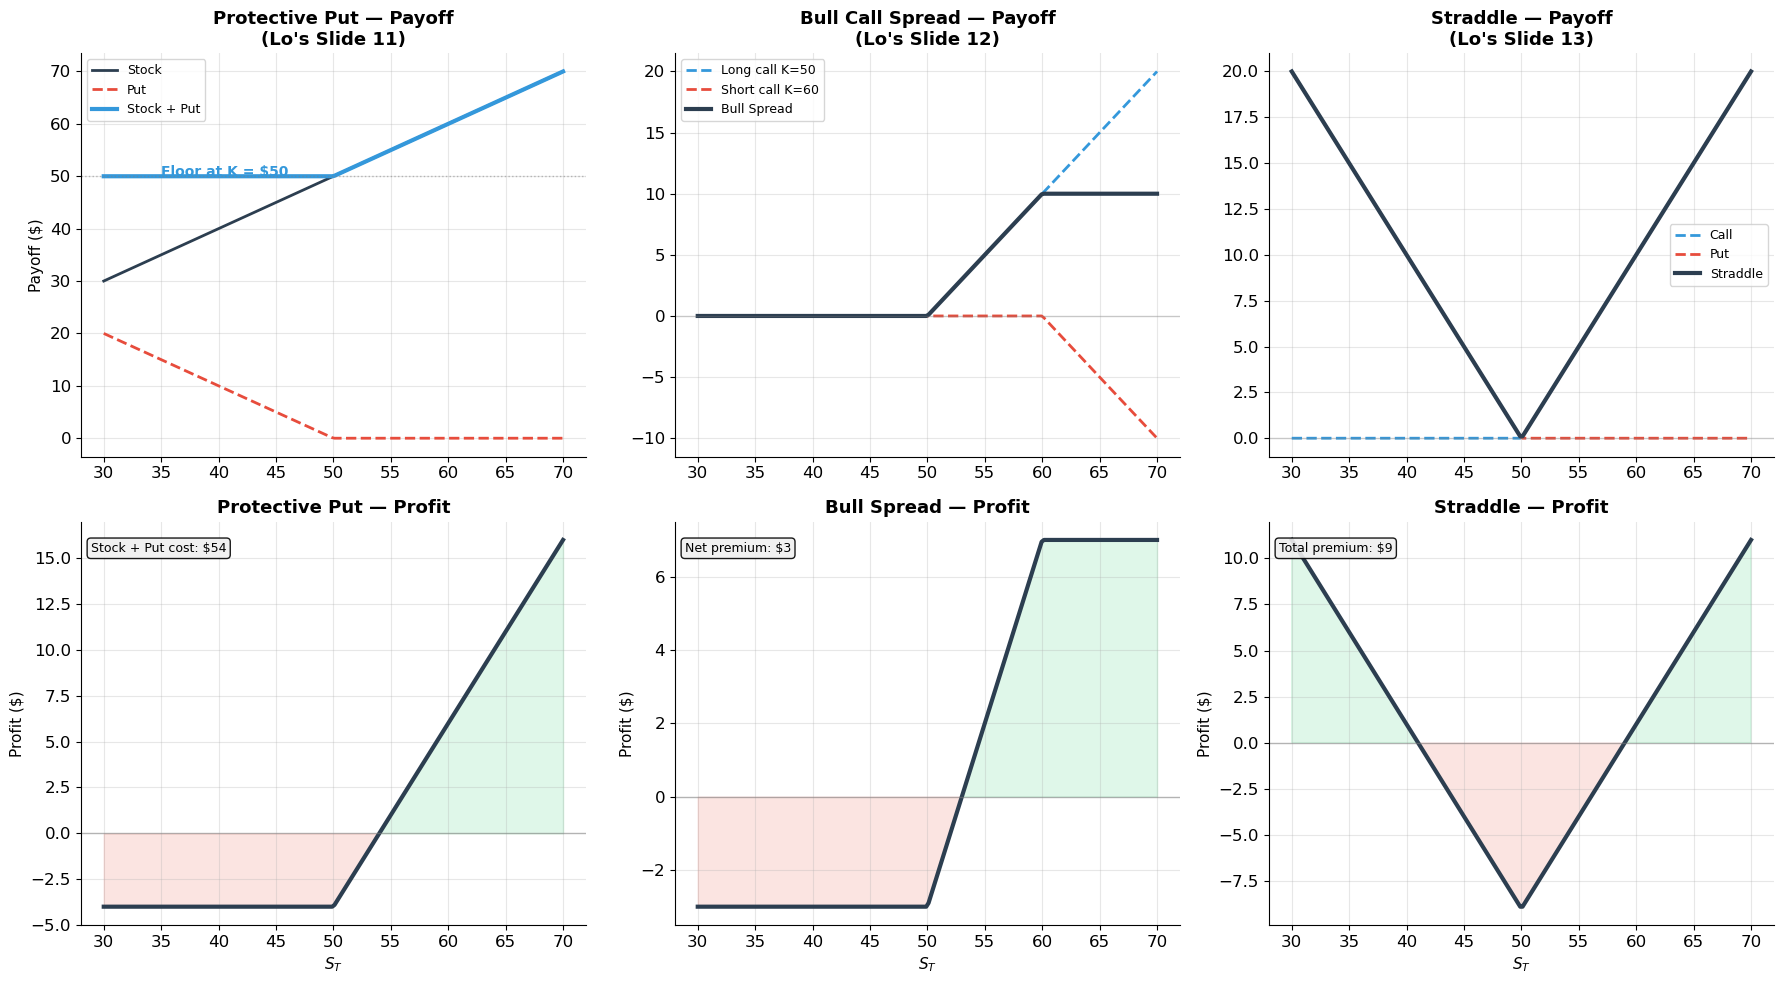

Strategy insights:
• Protective put: Insurance with a floor. You pay the put premium for downside protection.
• Bull spread: Cheaper than a naked call, but capped upside. Good for moderate bullish views.
• Straddle: A bet on VOLATILITY, not direction. Profits if the stock moves big in either direction.


In [9]:
# ============================================================
# Lo's Three Option Strategies (Slides 11-13)
# ============================================================
K = 50
K1, K2 = 50, 60
S = np.linspace(30, 70, 200)

# Premiums
C_K = 5       # call at K=50
C_K2 = 2      # call at K=60
P_K = 4       # put at K=50

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# --- Strategy 1: Protective Put (Slide 11) ---
stock_payoff = S
put_payoff = np.maximum(K - S, 0)
protput_payoff = stock_payoff + put_payoff
protput_profit = protput_payoff - (50 + P_K)

# Top row: payoff components
axes[0, 0].plot(S, stock_payoff, color='#2c3e50', linewidth=2, label='Stock')
axes[0, 0].plot(S, put_payoff, color='#e74c3c', linewidth=2, linestyle='--', label='Put')
axes[0, 0].plot(S, protput_payoff, color='#3498db', linewidth=3, label='Stock + Put')
axes[0, 0].axhline(y=K, color='gray', linewidth=1, linestyle=':', alpha=0.5)
axes[0, 0].set_title('Protective Put — Payoff\n(Lo\'s Slide 11)', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].set_ylabel('Payoff ($)', fontsize=11)
axes[0, 0].annotate(f'Floor at K = ${K}', xy=(35, K), fontsize=10, color='#3498db', fontweight='bold')

# --- Strategy 2: Bull Spread (Slide 12) ---
long_call = np.maximum(S - K1, 0)
short_call = -np.maximum(S - K2, 0)
spread_payoff = long_call + short_call
spread_profit = spread_payoff - (C_K - C_K2)

axes[0, 1].plot(S, long_call, color='#3498db', linewidth=2, linestyle='--', label=f'Long call K={K1}')
axes[0, 1].plot(S, short_call, color='#e74c3c', linewidth=2, linestyle='--', label=f'Short call K={K2}')
axes[0, 1].plot(S, spread_payoff, color='#2c3e50', linewidth=3, label='Bull Spread')
axes[0, 1].axhline(y=0, color='gray', linewidth=1, alpha=0.3)
axes[0, 1].set_title('Bull Call Spread — Payoff\n(Lo\'s Slide 12)', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=9)

# --- Strategy 3: Straddle (Slide 13) ---
call_K = np.maximum(S - K, 0)
put_K = np.maximum(K - S, 0)
straddle_payoff = call_K + put_K
straddle_profit = straddle_payoff - (C_K + P_K)

axes[0, 2].plot(S, call_K, color='#3498db', linewidth=2, linestyle='--', label='Call')
axes[0, 2].plot(S, put_K, color='#e74c3c', linewidth=2, linestyle='--', label='Put')
axes[0, 2].plot(S, straddle_payoff, color='#2c3e50', linewidth=3, label='Straddle')
axes[0, 2].axhline(y=0, color='gray', linewidth=1, alpha=0.3)
axes[0, 2].set_title('Straddle — Payoff\n(Lo\'s Slide 13)', fontsize=13, fontweight='bold')
axes[0, 2].legend(fontsize=9)

# Bottom row: profit diagrams
for ax, profit, title, cost_str in [
    (axes[1, 0], protput_profit, 'Protective Put', f'Stock + Put cost: ${50+P_K}'),
    (axes[1, 1], spread_profit, 'Bull Spread', f'Net premium: ${C_K - C_K2}'),
    (axes[1, 2], straddle_profit, 'Straddle', f'Total premium: ${C_K + P_K}'),
]:
    ax.plot(S, profit, color='#2c3e50', linewidth=3)
    ax.axhline(y=0, color='gray', linewidth=1, alpha=0.5)
    ax.fill_between(S, 0, profit, where=profit > 0, alpha=0.15, color='#2ecc71')
    ax.fill_between(S, 0, profit, where=profit < 0, alpha=0.15, color='#e74c3c')
    ax.set_title(f'{title} — Profit', fontsize=13, fontweight='bold')
    ax.set_xlabel('$S_T$', fontsize=11)
    ax.set_ylabel('Profit ($)', fontsize=11)
    ax.text(0.02, 0.95, cost_str, transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='#f0f0f0', alpha=0.9))

plt.tight_layout()
plt.show()

print("Strategy insights:")
print("• Protective put: Insurance with a floor. You pay the put premium for downside protection.")
print("• Bull spread: Cheaper than a naked call, but capped upside. Good for moderate bullish views.")
print("• Straddle: A bet on VOLATILITY, not direction. Profits if the stock moves big in either direction.")

---

<a id='4-parity'></a>
## 4. Put-Call Parity

### The Fundamental No-Arbitrage Relationship

Consider two portfolios:

**Portfolio A:** One call option with strike $K$ + Cash equal to $KB$ (= PV of $K$)

**Portfolio B:** One put option with strike $K$ + One share of stock

At expiration:

| State | Portfolio A | Portfolio B |
|-------|-----------|-----------|
| $S_T < K$ | $0 + K = K$ | $(K - S_T) + S_T = K$ |
| $S_T > K$ | $(S_T - K) + K = S_T$ | $0 + S_T = S_T$ |
| $S_T = K$ | $0 + K = K$ | $0 + K = K$ |

**Identical payoffs in every state!** Therefore, by no-arbitrage:

$$\boxed{C + KB = P + S \quad \Longleftrightarrow \quad C - P = S - KB}$$

where $B = 1/(1+r)^T$ is the discount factor (price of a zero-coupon bond paying \$1 at $T$).

This is **put-call parity** (for European options on non-dividend-paying stocks). It holds regardless of any model assumptions — it is a pure no-arbitrage result.

### Implications

- Knowing $C$, $S$, $K$, and $r$ determines $P$ (and vice versa). You don't need a pricing model!
- Violations create arbitrage opportunities.
- The relationship tells us: $\text{Call} - \text{Put} = \text{Stock} - \text{Bond}$. A call is like a "leveraged stock position" and a put is like "insurance".

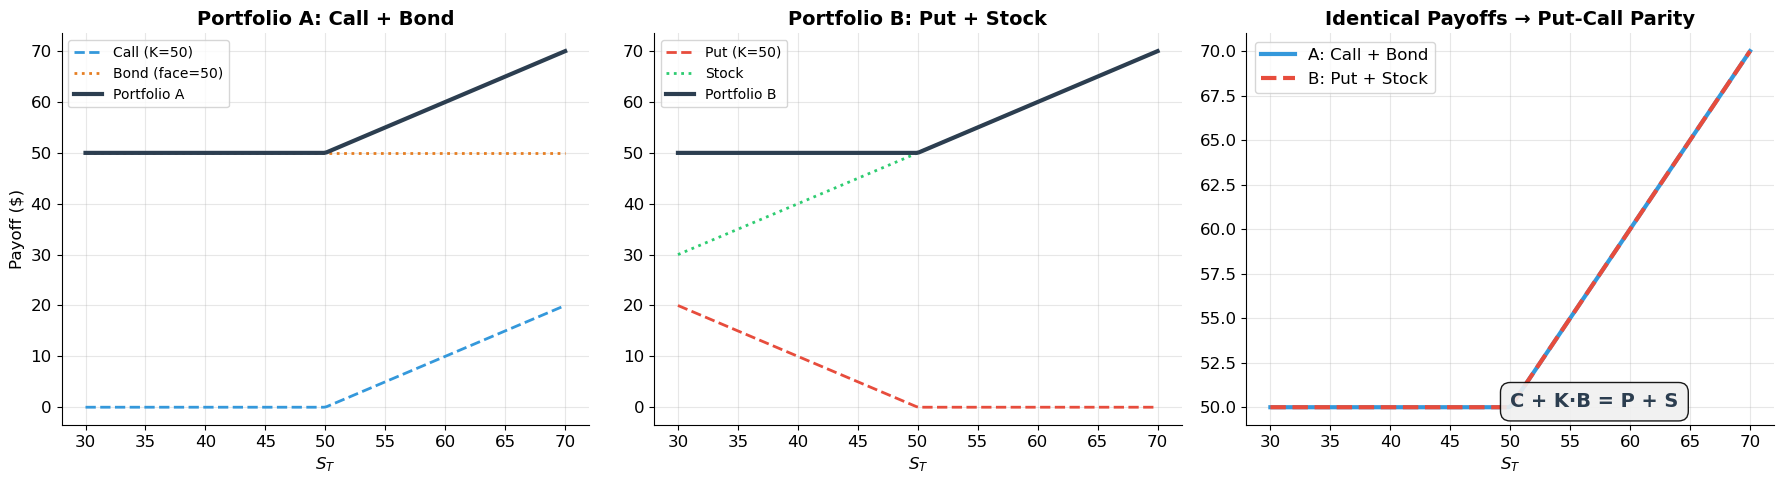

PUT-CALL PARITY — Numerical Example
S₀ = $50, K = $50, r = 5%, T = 0.5 years
Discount factor B = 1/(1+r)^T = 0.975900
K·B = $48.7950

Put-Call Parity: C + K·B = P + S
                 C - P = S - K·B = $50 - $48.7950 = $1.2050

If C = $4.00, then P = C - (S - KB) = $4.00 - $1.2050 = $2.7950


In [11]:
# ============================================================
# Put-Call Parity: Visual Proof
# ============================================================
K = 50
S = np.linspace(30, 70, 200)
B = 1 / 1.05  # discount factor (5% rate)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Portfolio A: Call + Bond
call_payoff = np.maximum(S - K, 0)
bond_payoff = np.full_like(S, K)
portA = call_payoff + bond_payoff

axes[0].plot(S, call_payoff, color='#3498db', linewidth=2, linestyle='--', label='Call (K=50)')
axes[0].plot(S, bond_payoff, color='#e67e22', linewidth=2, linestyle=':', label=f'Bond (face={K})')
axes[0].plot(S, portA, color='#2c3e50', linewidth=3, label='Portfolio A')
axes[0].set_title('Portfolio A: Call + Bond', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].set_xlabel('$S_T$', fontsize=12)
axes[0].set_ylabel('Payoff ($)', fontsize=12)

# Portfolio B: Put + Stock
put_payoff = np.maximum(K - S, 0)
stock_payoff = S
portB = put_payoff + stock_payoff

axes[1].plot(S, put_payoff, color='#e74c3c', linewidth=2, linestyle='--', label='Put (K=50)')
axes[1].plot(S, stock_payoff, color='#2ecc71', linewidth=2, linestyle=':', label='Stock')
axes[1].plot(S, portB, color='#2c3e50', linewidth=3, label='Portfolio B')
axes[1].set_title('Portfolio B: Put + Stock', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].set_xlabel('$S_T$', fontsize=12)

# Overlay both
axes[2].plot(S, portA, color='#3498db', linewidth=3, label='A: Call + Bond')
axes[2].plot(S, portB, color='#e74c3c', linewidth=3, linestyle='--', label='B: Put + Stock')
axes[2].set_title('Identical Payoffs → Put-Call Parity', fontsize=14, fontweight='bold')
axes[2].legend(fontsize=12)
axes[2].set_xlabel('$S_T$', fontsize=12)

axes[2].annotate('C + K·B = P + S', xy=(50, 50), fontsize=14,
                fontweight='bold', color='#2c3e50',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='#f0f0f0', alpha=0.9))

plt.tight_layout()
plt.show()

# Numerical example
S0 = 50; K = 50; r = 0.05; T = 0.5
B_val = 1 / (1 + r)**T
print("=" * 60)
print("PUT-CALL PARITY — Numerical Example")
print("=" * 60)
print(f"S₀ = ${S0}, K = ${K}, r = {r:.0%}, T = {T} years")
print(f"Discount factor B = 1/(1+r)^T = {B_val:.6f}")
print(f"K·B = ${K*B_val:.4f}")
print(f"\nPut-Call Parity: C + K·B = P + S")
print(f"                 C - P = S - K·B = ${S0} - ${K*B_val:.4f} = ${S0 - K*B_val:.4f}")
print(f"\nIf C = $4.00, then P = C - (S - KB) = $4.00 - ${S0 - K*B_val:.4f} = ${4.00 - (S0 - K*B_val):.4f}")

---

<a id='5-determinants'></a>
## 5. Determinants of Option Value

### Six Key Factors

| Factor | Effect on Call | Effect on Put | Intuition |
|--------|---------------|---------------|-----------|
| Stock price $S$ ↑ | ↑ | ↓ | Call more likely ITM; put less likely ITM |
| Strike price $K$ ↑ | ↓ | ↑ | Higher hurdle for call; bigger floor for put |
| Time to expiration $T$ ↑ | ↑ | ↑ | More time = more uncertainty = more option value |
| Volatility $\sigma$ ↑ | ↑ | ↑ | More dispersion = higher expected payoff |
| Interest rate $r$ ↑ | ↑ | ↓ | Lower PV of strike helps calls; hurts puts |
| Dividends $d$ ↑ | ↓ | ↑ | Lower stock price at ex-date hurts calls |

### The Crucial Role of Volatility

Lo and the lecture notes both emphasize: **option value increases with volatility**. This is unique to options — for stocks and bonds, higher risk typically means a lower price (higher discount rate). For options, higher volatility increases the *expected payoff* because options have asymmetric payoffs: they benefit from extreme moves in one direction but are protected from the other.

VOLATILITY AND OPTION VALUE
Both stocks: current price = $100, same expected value

   State   Prob   Firm A   A call   Firm B   B call
-------------------------------------------------------
       1  10.0% $    80 $     0 $    60 $     0
       2  20.0% $    90 $     0 $    80 $     0
       3  40.0% $   100 $     0 $   100 $     0
       4  20.0% $   110 $    10 $   120 $    20
       5  10.0% $   120 $    20 $   140 $    40
                ──────── ──────── ──────── ────────
    E[·]        $   100 $     4 $   100 $     8

Same expected stock price: E[A] = E[B] = $100
But E[call_B] = $8 > E[call_A] = $4

→ Higher volatility increases option value because the upside
  is captured (S - K when S > K) but the downside is truncated (payoff = 0).


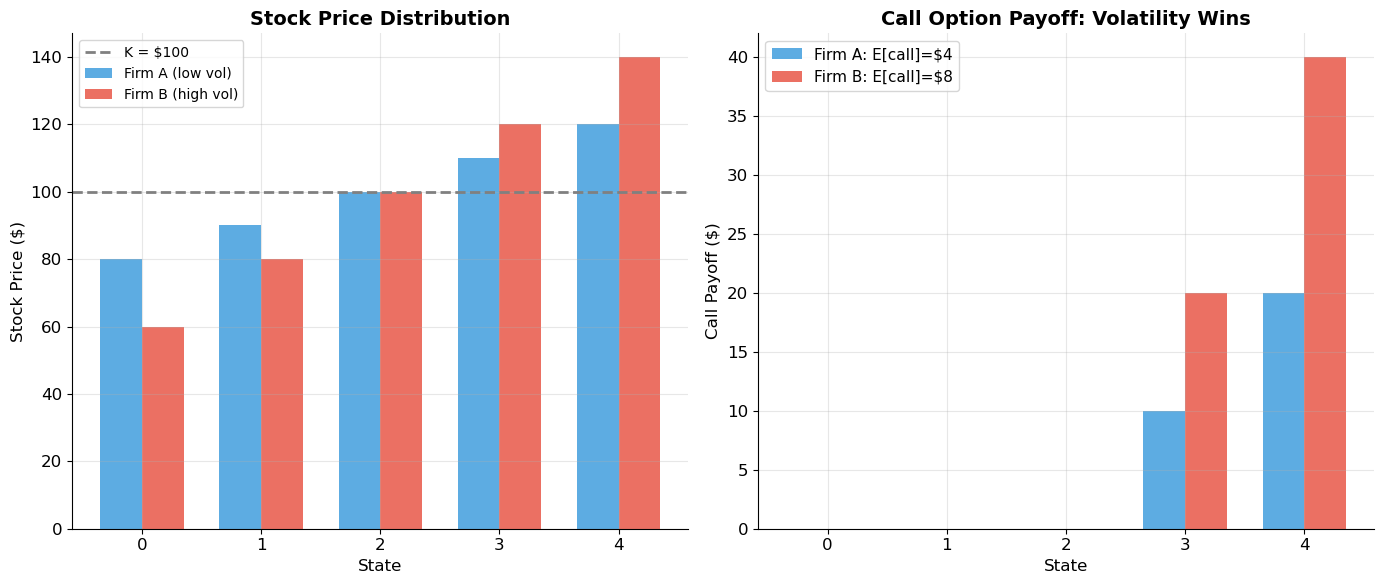

In [13]:
# ============================================================
# Volatility and Option Value
# ============================================================
# Two stocks: same price, different volatility
S0 = 100; K = 100

# Firm A: low vol
states_A = [80, 90, 100, 110, 120]
probs = [0.1, 0.2, 0.4, 0.2, 0.1]

# Firm B: high vol
states_B = [60, 80, 100, 120, 140]

# Expected stock price (same)
E_A = sum(s * p for s, p in zip(states_A, probs))
E_B = sum(s * p for s, p in zip(states_B, probs))

# Expected call payoff (different!)
E_call_A = sum(max(s - K, 0) * p for s, p in zip(states_A, probs))
E_call_B = sum(max(s - K, 0) * p for s, p in zip(states_B, probs))

print("=" * 60)
print("VOLATILITY AND OPTION VALUE")
print("=" * 60)
print(f"Both stocks: current price = ${S0}, same expected value")
print(f"\n{'State':>8s} {'Prob':>6s} {'Firm A':>8s} {'A call':>8s} {'Firm B':>8s} {'B call':>8s}")
print("-" * 55)
for i in range(5):
    ca = max(states_A[i] - K, 0)
    cb = max(states_B[i] - K, 0)
    print(f"{i+1:>8d} {probs[i]:>6.1%} ${states_A[i]:>6d} ${ca:>6d} ${states_B[i]:>6d} ${cb:>6d}")

print(f"{'':>8s} {'':>6s} {'─'*8} {'─'*8} {'─'*8} {'─'*8}")
print(f"{'E[·]':>8s} {'':>6s} ${E_A:>6.0f} ${E_call_A:>6.0f} ${E_B:>6.0f} ${E_call_B:>6.0f}")
print(f"\nSame expected stock price: E[A] = E[B] = ${E_A:.0f}")
print(f"But E[call_B] = ${E_call_B:.0f} > E[call_A] = ${E_call_A:.0f}")
print(f"\n→ Higher volatility increases option value because the upside")
print(f"  is captured (S - K when S > K) but the downside is truncated (payoff = 0).")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

x = np.arange(5)
width = 0.35
ax1.bar(x - width/2, states_A, width, color='#3498db', alpha=0.8, label='Firm A (low vol)')
ax1.bar(x + width/2, states_B, width, color='#e74c3c', alpha=0.8, label='Firm B (high vol)')
ax1.axhline(y=K, color='gray', linewidth=2, linestyle='--', label=f'K = ${K}')
ax1.set_xlabel('State', fontsize=12)
ax1.set_ylabel('Stock Price ($)', fontsize=12)
ax1.set_title('Stock Price Distribution', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)

call_A = [max(s - K, 0) for s in states_A]
call_B = [max(s - K, 0) for s in states_B]
ax2.bar(x - width/2, call_A, width, color='#3498db', alpha=0.8, label=f'Firm A: E[call]=${E_call_A:.0f}')
ax2.bar(x + width/2, call_B, width, color='#e74c3c', alpha=0.8, label=f'Firm B: E[call]=${E_call_B:.0f}')
ax2.set_xlabel('State', fontsize=12)
ax2.set_ylabel('Call Payoff ($)', fontsize=12)
ax2.set_title('Call Option Payoff: Volatility Wins', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)

plt.tight_layout()
plt.show()

---

<a id='6-binomial'></a>
## 6. The Binomial Option-Pricing Model

### The Setup (Lo's Slides 16–21)

Consider a one-period model:
- Current stock price: $S_0$
- Tomorrow: stock goes **up** to $uS_0$ with probability $p$, or **down** to $dS_0$ with probability $(1-p)$
- Risk-free rate: $r$ (so \$1 today becomes \$r$ tomorrow, where $r = 1 + r_f$)
- European call with strike $K$, expiring tomorrow

$$\text{Call payoff: } C_u = \max(uS_0 - K, 0) \text{ or } C_d = \max(dS_0 - K, 0)$$

### The Replicating Portfolio Argument

**Key idea:** Construct a portfolio of $\Delta$ shares of stock and \$B in bonds that replicates the option payoff:

$$uS_0 \Delta + rB = C_u \quad \text{(up state)}$$
$$dS_0 \Delta + rB = C_d \quad \text{(down state)}$$

Solving these two equations:

$$\boxed{\Delta^* = \frac{C_u - C_d}{(u - d)S_0}} \qquad \boxed{B^* = \frac{uC_d - dC_u}{(u - d)r}}$$

Since this portfolio has **identical payoffs** to the option in every state, no-arbitrage requires:

$$\boxed{C_0 = S_0 \Delta^* + B^* = \frac{1}{r}\left[\frac{r - d}{u - d}C_u + \frac{u - r}{u - d}C_d\right]}$$

### The Stunning Result

**The probability $p$ does not appear anywhere in the formula!**

Two investors who disagree completely about the probability of the stock going up must still agree on the option price. The option price is determined entirely by $S_0$, $u$, $d$, $r$, and $K$ — all observable quantities.

The terms $q = (r-d)/(u-d)$ and $(1-q) = (u-r)/(u-d)$ are called **risk-neutral probabilities**. They are not real probabilities — they are mathematical weights that arise from the replication argument.

In [15]:
# ============================================================
# One-Period Binomial Model — Detailed Derivation
# ============================================================

def binomial_one_period(S0, K, u, d, r):
    """One-period binomial option pricing.
    
    Returns: C0, delta, B, Cu, Cd, q
    r here is the GROSS risk-free rate (e.g. 1.10 for 10%).
    """
    Su = u * S0
    Sd = d * S0
    Cu = max(Su - K, 0)
    Cd = max(Sd - K, 0)
    
    delta = (Cu - Cd) / ((u - d) * S0)
    B = (u * Cd - d * Cu) / ((u - d) * r)
    C0 = S0 * delta + B
    
    # Risk-neutral probability
    q = (r - d) / (u - d)
    C0_check = (q * Cu + (1 - q) * Cd) / r
    
    return C0, delta, B, Cu, Cd, q


# Lecture notes example: S0=50, u=1.5, d=0.5, K=50, r=1.10
S0 = 50; K = 50; u = 1.5; d = 0.5; r = 1.10
C0, delta, B, Cu, Cd, q = binomial_one_period(S0, K, u, d, r)

print("=" * 70)
print("ONE-PERIOD BINOMIAL — Lecture Notes Example")
print("=" * 70)
print(f"S₀ = ${S0},  K = ${K},  u = {u},  d = {d},  r = {r}")
print(f"\nStock tree:")
print(f"  uS₀ = {u}×{S0} = ${u*S0:.0f}  (up state)")
print(f"  dS₀ = {d}×{S0} = ${d*S0:.0f}  (down state)")
print(f"\nCall payoffs:")
print(f"  Cᵤ = max({u*S0:.0f} - {K}, 0) = ${Cu:.2f}")
print(f"  C_d = max({d*S0:.0f} - {K}, 0) = ${Cd:.2f}")
print(f"\nReplicating portfolio:")
print(f"  Δ* = (Cᵤ - C_d)/((u-d)S₀) = ({Cu}-{Cd})/(({u}-{d})×{S0}) = {delta:.4f}")
print(f"  B* = (uC_d - dCᵤ)/((u-d)r) = ({u}×{Cd} - {d}×{Cu})/(({u}-{d})×{r}) = ${B:.4f}")
print(f"\nVerification:")
print(f"  Up state:   {delta:.4f}×{u*S0:.0f} + {r}×({B:.4f}) = {delta*u*S0 + r*B:.4f} = Cᵤ = {Cu:.2f} ✓")
print(f"  Down state: {delta:.4f}×{d*S0:.0f} + {r}×({B:.4f}) = {delta*d*S0 + r*B:.4f} = C_d = {Cd:.2f} ✓")
print(f"\nOption price:")
print(f"  C₀ = S₀Δ* + B* = {S0}×{delta:.4f} + ({B:.4f}) = ${C0:.4f}")
print(f"\nRisk-neutral probability:")
print(f"  q = (r-d)/(u-d) = ({r}-{d})/({u}-{d}) = {q:.4f}")
print(f"  C₀ = [q·Cᵤ + (1-q)·C_d]/r = [{q:.4f}×{Cu} + {1-q:.4f}×{Cd}]/{r} = ${(q*Cu+(1-q)*Cd)/r:.4f} ✓")
print(f"\nDelta (hedge ratio) = {delta:.4f}")
print(f"  → To hedge one call, hold {delta:.4f} shares and borrow ${-B:.2f}")

ONE-PERIOD BINOMIAL — Lecture Notes Example
S₀ = $50,  K = $50,  u = 1.5,  d = 0.5,  r = 1.1

Stock tree:
  uS₀ = 1.5×50 = $75  (up state)
  dS₀ = 0.5×50 = $25  (down state)

Call payoffs:
  Cᵤ = max(75 - 50, 0) = $25.00
  C_d = max(25 - 50, 0) = $0.00

Replicating portfolio:
  Δ* = (Cᵤ - C_d)/((u-d)S₀) = (25.0-0)/((1.5-0.5)×50) = 0.5000
  B* = (uC_d - dCᵤ)/((u-d)r) = (1.5×0 - 0.5×25.0)/((1.5-0.5)×1.1) = $-11.3636

Verification:
  Up state:   0.5000×75 + 1.1×(-11.3636) = 25.0000 = Cᵤ = 25.00 ✓
  Down state: 0.5000×25 + 1.1×(-11.3636) = 0.0000 = C_d = 0.00 ✓

Option price:
  C₀ = S₀Δ* + B* = 50×0.5000 + (-11.3636) = $13.6364

Risk-neutral probability:
  q = (r-d)/(u-d) = (1.1-0.5)/(1.5-0.5) = 0.6000
  C₀ = [q·Cᵤ + (1-q)·C_d]/r = [0.6000×25.0 + 0.4000×0]/1.1 = $13.6364 ✓

Delta (hedge ratio) = 0.5000
  → To hedge one call, hold 0.5000 shares and borrow $11.36


In [16]:
# ============================================================
# Two-Period Binomial Tree — Full Worked Example
# ============================================================

def binomial_tree(S0, K, u, d, r, n, option_type='call', american=False):
    """N-period binomial tree for European/American call or put.
    r is GROSS rate per period.
    Returns: price, stock_tree, option_tree, delta_tree
    """
    # Build stock tree
    stock = np.zeros((n + 1, n + 1))
    for i in range(n + 1):
        for j in range(i + 1):
            stock[j, i] = S0 * u**(i - j) * d**j
    
    # Option payoff at maturity
    opt = np.zeros((n + 1, n + 1))
    for j in range(n + 1):
        if option_type == 'call':
            opt[j, n] = max(stock[j, n] - K, 0)
        else:
            opt[j, n] = max(K - stock[j, n], 0)
    
    # Risk-neutral probability
    q = (r - d) / (u - d)
    
    # Backward induction
    delta = np.zeros((n, n))
    for i in range(n - 1, -1, -1):
        for j in range(i + 1):
            continuation = (q * opt[j, i + 1] + (1 - q) * opt[j + 1, i + 1]) / r
            if american:
                if option_type == 'call':
                    exercise = max(stock[j, i] - K, 0)
                else:
                    exercise = max(K - stock[j, i], 0)
                opt[j, i] = max(continuation, exercise)
            else:
                opt[j, i] = continuation
            # Delta at each node
            delta[j, i] = (opt[j, i+1] - opt[j+1, i+1]) / (stock[j, i+1] - stock[j+1, i+1])
    
    return opt[0, 0], stock, opt, delta


# Two-period example from lecture notes
S0 = 50; K = 50; u = 1.5; d = 0.5; r = 1.10; n = 2

C0, stock, opt, delta = binomial_tree(S0, K, u, d, r, n, 'call')

print("=" * 70)
print("TWO-PERIOD BINOMIAL TREE — Lecture Notes Example")
print(f"S₀ = ${S0}, K = ${K}, u = {u}, d = {d}, r = {r}, n = {n}")
print("=" * 70)

# Display stock tree
print("\nStock price tree:")
for j in range(n + 1):
    row = []
    for i in range(n + 1):
        if j <= i:
            row.append(f"${stock[j, i]:>7.2f}")
        else:
            row.append(f"{'':>8s}")
    print("  ".join(row))

print("\nOption value tree:")
for j in range(n + 1):
    row = []
    for i in range(n + 1):
        if j <= i:
            row.append(f"${opt[j, i]:>7.2f}")
        else:
            row.append(f"{'':>8s}")
    print("  ".join(row))

print(f"\nDelta (hedge ratio) tree:")
for j in range(n):
    row = []
    for i in range(n):
        if j <= i:
            row.append(f"{delta[j, i]:>7.4f}")
        else:
            row.append(f"{'':>8s}")
    print("  ".join(row))

print(f"\nCall price C₀ = ${C0:.4f}")
print(f"\nStep-by-step (matching lecture notes):")
print(f"  Period 2 payoffs: Cuu=${opt[0,2]:.2f}, Cud=${opt[1,2]:.2f}, Cdd=${opt[2,2]:.2f}")

# Verify Cu from period 1
q = (r - d) / (u - d)
Cu_check = (q * opt[0, 2] + (1 - q) * opt[1, 2]) / r
Cd_check = (q * opt[1, 2] + (1 - q) * opt[2, 2]) / r
print(f"  Period 1: Cu = (q×Cuu + (1-q)×Cud)/r = ({q:.3f}×{opt[0,2]:.2f} + {1-q:.3f}×{opt[1,2]:.2f})/{r} = ${Cu_check:.3f}")
print(f"            Cd = (q×Cud + (1-q)×Cdd)/r = ({q:.3f}×{opt[1,2]:.2f} + {1-q:.3f}×{opt[2,2]:.2f})/{r} = ${Cd_check:.3f}")
C0_check = (q * Cu_check + (1 - q) * Cd_check) / r
print(f"  Period 0: C0 = (q×Cu + (1-q)×Cd)/r = ({q:.3f}×{Cu_check:.3f} + {1-q:.3f}×{Cd_check:.3f})/{r} = ${C0_check:.3f}")
print(f"\n  Exercise value at period 1 up-node: ${u*S0 - K:.2f}")
print(f"  Continuation value:                 ${Cu_check:.3f}")
print(f"  No early exercise (Cu > exercise) ✓")

TWO-PERIOD BINOMIAL TREE — Lecture Notes Example
S₀ = $50, K = $50, u = 1.5, d = 0.5, r = 1.1, n = 2

Stock price tree:
$  50.00  $  75.00  $ 112.50
          $  25.00  $  37.50
                    $  12.50

Option value tree:
$  18.60  $  34.09  $  62.50
          $   0.00  $   0.00
                    $   0.00

Delta (hedge ratio) tree:
 0.6818   0.8333
           0.0000

Call price C₀ = $18.5950

Step-by-step (matching lecture notes):
  Period 2 payoffs: Cuu=$62.50, Cud=$0.00, Cdd=$0.00
  Period 1: Cu = (q×Cuu + (1-q)×Cud)/r = (0.600×62.50 + 0.400×0.00)/1.1 = $34.091
            Cd = (q×Cud + (1-q)×Cdd)/r = (0.600×0.00 + 0.400×0.00)/1.1 = $0.000
  Period 0: C0 = (q×Cu + (1-q)×Cd)/r = (0.600×34.091 + 0.400×0.000)/1.1 = $18.595

  Exercise value at period 1 up-node: $25.00
  Continuation value:                 $34.091
  No early exercise (Cu > exercise) ✓


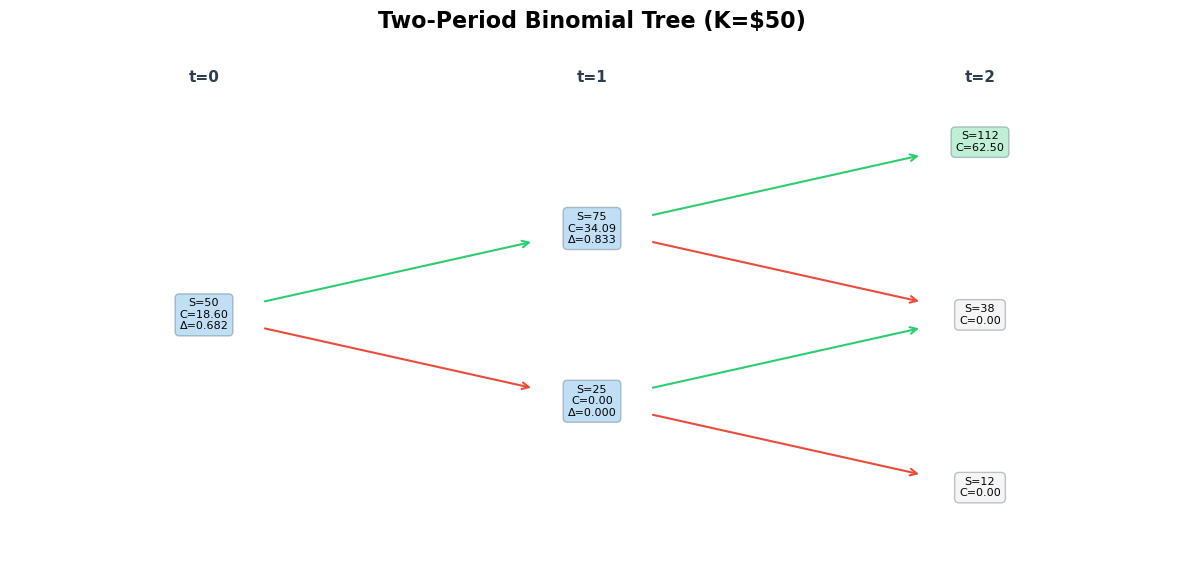

Green nodes at maturity = in-the-money (positive payoff)
Δ changes at each node — the replicating portfolio must be rebalanced dynamically


In [17]:
# ============================================================
# Binomial Tree Visualization
# ============================================================

def draw_binomial_tree(stock, opt, delta, n, title, K):
    """Visualize the binomial tree."""
    fig, ax = plt.subplots(figsize=(max(12, 3*n), max(6, 2*n)))
    ax.set_xlim(-0.5, n + 0.5)
    y_vals = []
    for i in range(n + 1):
        for j in range(i + 1):
            y_vals.append(i - 2*j)
    y_min, y_max = min(y_vals) - 1, max(y_vals) + 1
    ax.set_ylim(y_min, y_max)
    ax.axis('off')
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    
    # Draw nodes and edges
    for i in range(n + 1):
        for j in range(i + 1):
            x = i
            y = i - 2 * j
            
            # Color based on option value
            if i == n:
                color = '#2ecc71' if opt[j, i] > 0 else '#e0e0e0'
            else:
                color = '#3498db'
            
            # Node
            txt = f"S={stock[j,i]:.0f}\nC={opt[j,i]:.2f}"
            if i < n:
                txt += f"\nΔ={delta[j,i]:.3f}"
            
            ax.annotate(txt, xy=(x, y), fontsize=8, ha='center', va='center',
                       bbox=dict(boxstyle='round,pad=0.4', facecolor=color, alpha=0.3, edgecolor='#2c3e50'))
            
            # Edges to next period
            if i < n:
                # Up
                x_next_u, y_next_u = i + 1, (i + 1) - 2 * j
                ax.annotate('', xy=(x_next_u - 0.15, y_next_u - 0.15), xytext=(x + 0.15, y + 0.15),
                           arrowprops=dict(arrowstyle='->', color='#2ecc71', lw=1.5))
                # Down
                x_next_d, y_next_d = i + 1, (i + 1) - 2 * (j + 1)
                ax.annotate('', xy=(x_next_d - 0.15, y_next_d + 0.15), xytext=(x + 0.15, y - 0.15),
                           arrowprops=dict(arrowstyle='->', color='#e74c3c', lw=1.5))
    
    # Period labels
    for i in range(n + 1):
        ax.text(i, y_max - 0.3, f't={i}', ha='center', fontsize=11, fontweight='bold', color='#2c3e50')
    
    plt.tight_layout()
    plt.show()


draw_binomial_tree(stock, opt, delta, n, f'Two-Period Binomial Tree (K=${K})', K)

print("Green nodes at maturity = in-the-money (positive payoff)")
print("Δ changes at each node — the replicating portfolio must be rebalanced dynamically")

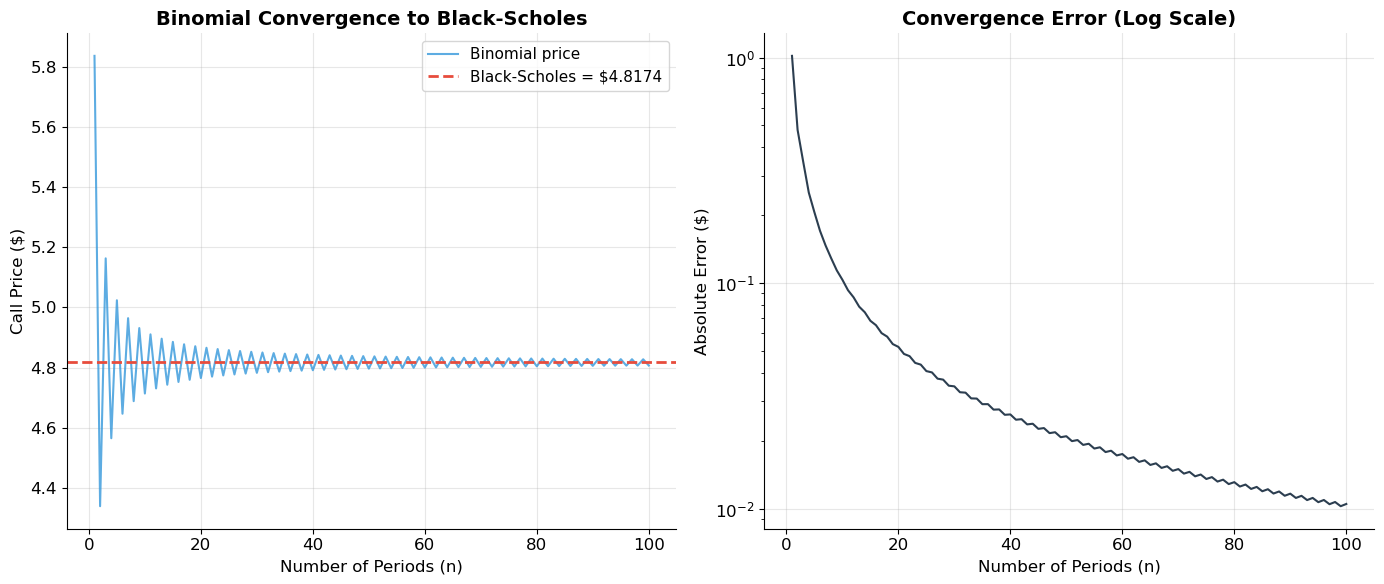

Black-Scholes price: $4.8174
  n =   5: Binomial = $5.0237, error = $0.2063
  n =  10: Binomial = $4.7139, error = $0.1035
  n =  25: Binomial = $4.8582, error = $0.0407
  n =  50: Binomial = $4.7965, error = $0.0209
  n = 100: Binomial = $4.8070, error = $0.0105

As n → ∞, the binomial model converges to Black-Scholes.
In practice, n = 50-100 steps gives excellent accuracy.


In [18]:
# ============================================================
# Multi-Period Convergence: Binomial → Black-Scholes
# ============================================================
# ▶ MODIFY AND RE-RUN
S0 = 50
K = 50
rf_annual = 0.05    # annual risk-free rate
sigma = 0.30        # annual volatility
T = 0.5             # 6 months
# ============================================================

# Black-Scholes price for comparison
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

BS_price = black_scholes_call(S0, K, T, rf_annual, sigma)

# Compute binomial prices for increasing n
n_values = list(range(1, 101))
binom_prices = []

for n in n_values:
    dt = T / n
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    r_per = np.exp(rf_annual * dt)  # gross rate per period
    
    price, _, _, _ = binomial_tree(S0, K, u, d, r_per, n, 'call')
    binom_prices.append(price)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(n_values, binom_prices, color='#3498db', linewidth=1.5, alpha=0.8, label='Binomial price')
ax1.axhline(y=BS_price, color='#e74c3c', linewidth=2, linestyle='--', label=f'Black-Scholes = ${BS_price:.4f}')
ax1.set_xlabel('Number of Periods (n)', fontsize=12)
ax1.set_ylabel('Call Price ($)', fontsize=12)
ax1.set_title('Binomial Convergence to Black-Scholes', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)

# Error plot
errors = [abs(bp - BS_price) for bp in binom_prices]
ax2.semilogy(n_values, errors, color='#2c3e50', linewidth=1.5)
ax2.set_xlabel('Number of Periods (n)', fontsize=12)
ax2.set_ylabel('Absolute Error ($)', fontsize=12)
ax2.set_title('Convergence Error (Log Scale)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Black-Scholes price: ${BS_price:.4f}")
for n in [5, 10, 25, 50, 100]:
    print(f"  n = {n:>3d}: Binomial = ${binom_prices[n-1]:.4f}, error = ${abs(binom_prices[n-1]-BS_price):.4f}")
print(f"\nAs n → ∞, the binomial model converges to Black-Scholes.")
print(f"In practice, n = 50-100 steps gives excellent accuracy.")

---

<a id='7-black-scholes'></a>
## 7. The Black-Scholes Formula

### The Continuous-Time Limit

As the number of binomial periods $n \to \infty$ (with the period length shrinking proportionally), the binomial model converges to the **Black-Scholes-Merton** formula:

$$\boxed{C = S_0 N(d_1) - K e^{-rT} N(d_2)}$$

$$\boxed{P = K e^{-rT} N(-d_2) - S_0 N(-d_1)}$$

where:

$$d_1 = \frac{\ln(S_0/K) + (r + \sigma^2/2)T}{\sigma\sqrt{T}}, \qquad d_2 = d_1 - \sigma\sqrt{T}$$

- $N(\cdot)$: cumulative standard normal distribution
- $\sigma$: annualized volatility of the underlying
- $r$: continuously compounded risk-free rate
- $T$: time to expiration (in years)

### Interpretation

The call price $C = S_0 N(d_1) - Ke^{-rT}N(d_2)$ is the cost of the **replicating portfolio**:
- $N(d_1) = \Delta$ = number of shares (the option's delta)
- $Ke^{-rT}N(d_2)$ = dollars borrowed

Just like the binomial model: **a call is a leveraged stock position**. The delta $N(d_1)$ is the continuous-time analogue of $\Delta^*$ from the binomial model.

### Five Inputs, No Probability

The Black-Scholes formula requires only: $S_0$, $K$, $T$, $r$, and $\sigma$. Like the binomial model, it does **not** require the expected return on the stock or investors' risk preferences.

In [20]:
# ============================================================
# Black-Scholes Pricing and the Greeks
# ============================================================
# ▶ MODIFY AND RE-RUN
S0 = 50
K = 50
T = 30 / 365   # 30 days (matching lecture notes example)
r = np.log(1.05895)  # continuously compounded (~5.73%)
sigma = 0.30
# ============================================================

C = black_scholes_call(S0, K, T, r, sigma)
P = black_scholes_put(S0, K, T, r, sigma)

d1 = (np.log(S0 / K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)

print("=" * 65)
print("BLACK-SCHOLES PRICING — Lecture Notes Example")
print("=" * 65)
print(f"S₀ = ${S0}, K = ${K}, T = {T:.4f} yr ({T*365:.0f} days), r = {r:.4f}, σ = {sigma:.0%}")
print(f"\nd₁ = [ln(S/K) + (r + σ²/2)T] / (σ√T)")
print(f"   = [ln({S0}/{K}) + ({r:.4f} + {sigma**2/2:.4f})×{T:.4f}] / ({sigma}×{np.sqrt(T):.4f})")
print(f"   = {d1:.6f}")
print(f"d₂ = d₁ - σ√T = {d1:.6f} - {sigma*np.sqrt(T):.6f} = {d2:.6f}")
print(f"\nN(d₁) = {norm.cdf(d1):.6f}  (delta)")
print(f"N(d₂) = {norm.cdf(d2):.6f}")
print(f"\nCall: C = S·N(d₁) - K·e^(-rT)·N(d₂)")
print(f"       = {S0}×{norm.cdf(d1):.6f} - {K}×{np.exp(-r*T):.6f}×{norm.cdf(d2):.6f}")
print(f"       = ${C:.4f}")
print(f"\nPut:  P = K·e^(-rT)·N(-d₂) - S·N(-d₁)")
print(f"       = ${P:.4f}")

# Verify put-call parity
parity_check = C + K * np.exp(-r * T) - P - S0
print(f"\nPut-call parity check: C + K·e^(-rT) - P - S = {parity_check:.10f} ≈ 0 ✓")

BLACK-SCHOLES PRICING — Lecture Notes Example
S₀ = $50, K = $50, T = 0.0822 yr (30 days), r = 0.0573, σ = 30%

d₁ = [ln(S/K) + (r + σ²/2)T] / (σ√T)
   = [ln(50/50) + (0.0573 + 0.0450)×0.0822] / (0.3×0.2867)
   = 0.097740
d₂ = d₁ - σ√T = 0.097740 - 0.086007 = 0.011733

N(d₁) = 0.538931  (delta)
N(d₂) = 0.504681

Call: C = S·N(d₁) - K·e^(-rT)·N(d₂)
       = 50×0.538931 - 50×0.995303×0.504681
       = $1.8310

Put:  P = K·e^(-rT)·N(-d₂) - S·N(-d₁)
       = $1.5962

Put-call parity check: C + K·e^(-rT) - P - S = 0.0000000000 ≈ 0 ✓


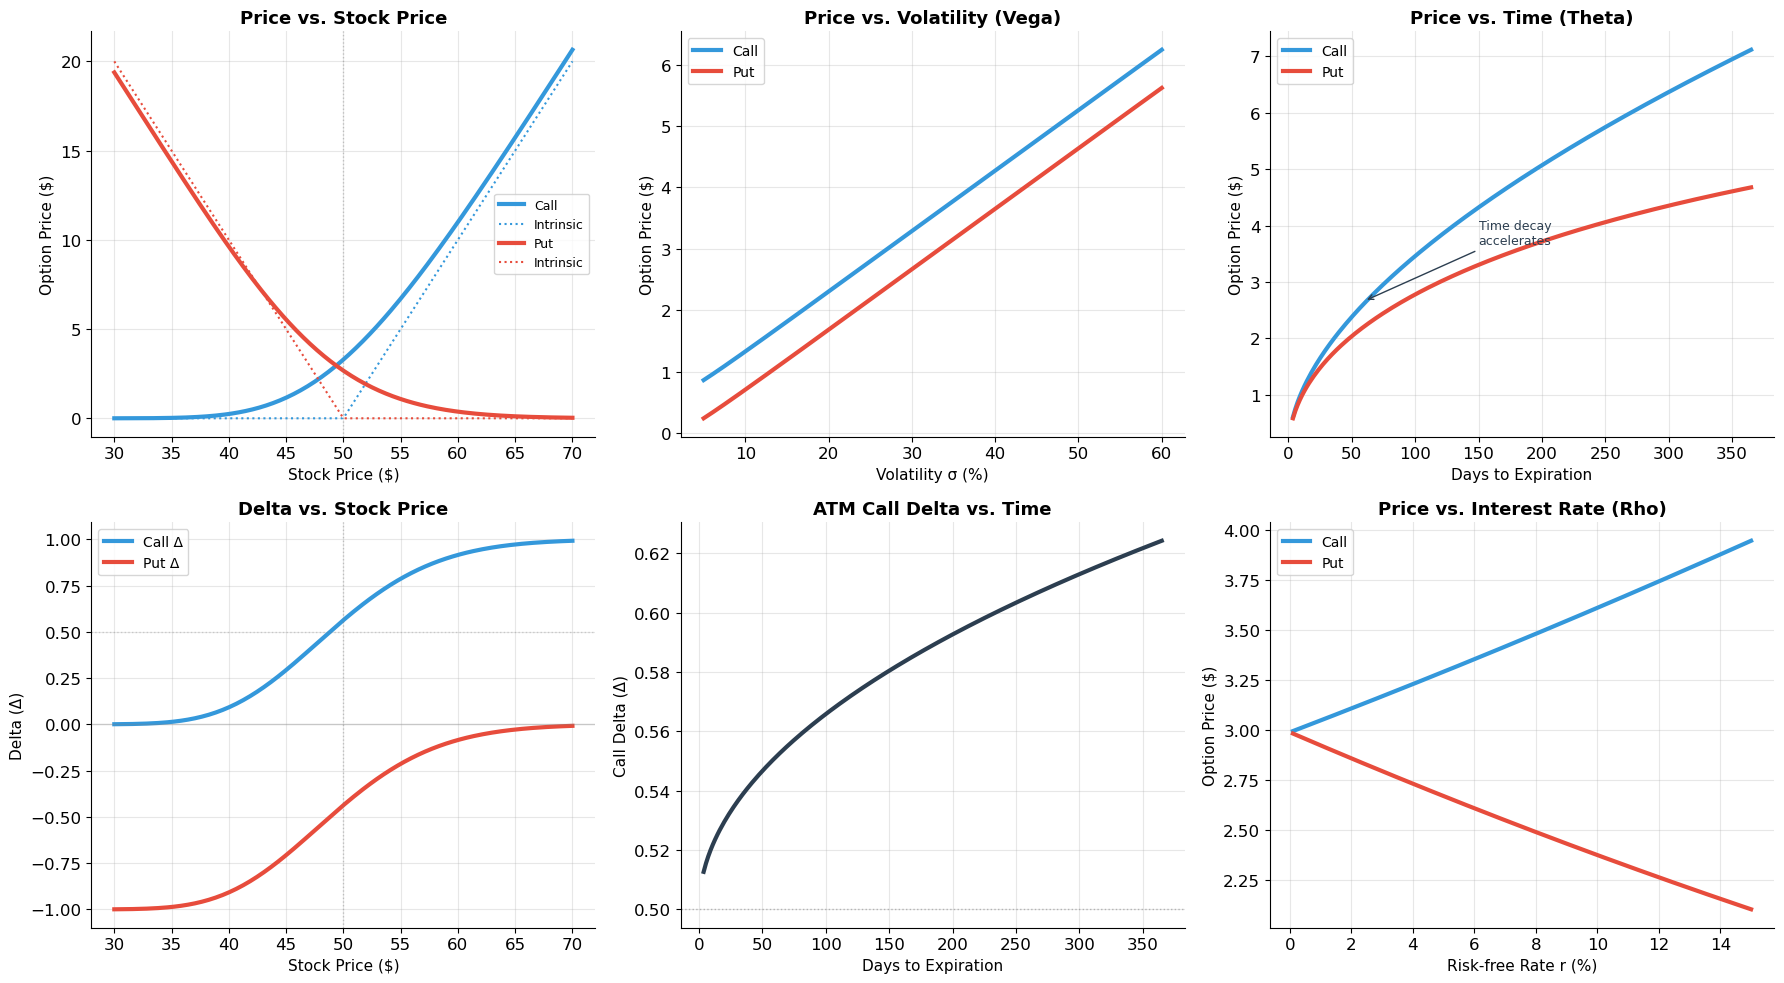

Key sensitivity insights:
• Stock price: Call Δ ∈ [0,1]; deep ITM → Δ≈1; deep OTM → Δ≈0; ATM → Δ≈0.5
• Volatility: BOTH calls and puts increase with σ (unique to options)
• Time: Options lose value as expiration approaches ('time decay' / 'theta')
• Time decay accelerates near expiration — the last 30 days are critical


In [21]:
# ============================================================
# Sensitivity Analysis: The Greeks (Visually)
# ============================================================
S0 = 50; K = 50; T = 0.25; r = 0.05; sigma = 0.30

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. Price vs. S (delta)
S_range = np.linspace(30, 70, 200)
calls = [black_scholes_call(S, K, T, r, sigma) for S in S_range]
puts = [black_scholes_put(S, K, T, r, sigma) for S in S_range]
intrinsic_call = [max(S - K, 0) for S in S_range]
intrinsic_put = [max(K - S, 0) for S in S_range]

axes[0, 0].plot(S_range, calls, color='#3498db', linewidth=3, label='Call')
axes[0, 0].plot(S_range, intrinsic_call, color='#3498db', linewidth=1.5, linestyle=':', label='Intrinsic')
axes[0, 0].plot(S_range, puts, color='#e74c3c', linewidth=3, label='Put')
axes[0, 0].plot(S_range, intrinsic_put, color='#e74c3c', linewidth=1.5, linestyle=':', label='Intrinsic')
axes[0, 0].set_xlabel('Stock Price ($)', fontsize=11)
axes[0, 0].set_ylabel('Option Price ($)', fontsize=11)
axes[0, 0].set_title('Price vs. Stock Price', fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=9)
axes[0, 0].axvline(x=K, color='gray', linewidth=1, linestyle=':', alpha=0.4)

# 2. Price vs. sigma (vega)
sig_range = np.linspace(0.05, 0.60, 200)
c_sig = [black_scholes_call(S0, K, T, r, s) for s in sig_range]
p_sig = [black_scholes_put(S0, K, T, r, s) for s in sig_range]
axes[0, 1].plot(sig_range * 100, c_sig, color='#3498db', linewidth=3, label='Call')
axes[0, 1].plot(sig_range * 100, p_sig, color='#e74c3c', linewidth=3, label='Put')
axes[0, 1].set_xlabel('Volatility σ (%)', fontsize=11)
axes[0, 1].set_ylabel('Option Price ($)', fontsize=11)
axes[0, 1].set_title('Price vs. Volatility (Vega)', fontsize=13, fontweight='bold')
axes[0, 1].legend(fontsize=10)

# 3. Price vs. T (theta)
T_range = np.linspace(0.01, 1.0, 200)
c_T = [black_scholes_call(S0, K, t, r, sigma) for t in T_range]
p_T = [black_scholes_put(S0, K, t, r, sigma) for t in T_range]
axes[0, 2].plot(T_range * 365, c_T, color='#3498db', linewidth=3, label='Call')
axes[0, 2].plot(T_range * 365, p_T, color='#e74c3c', linewidth=3, label='Put')
axes[0, 2].set_xlabel('Days to Expiration', fontsize=11)
axes[0, 2].set_ylabel('Option Price ($)', fontsize=11)
axes[0, 2].set_title('Price vs. Time (Theta)', fontsize=13, fontweight='bold')
axes[0, 2].legend(fontsize=10)
axes[0, 2].annotate('Time decay\naccelerates', xy=(60, c_T[int(60/365*200)]),
                    xytext=(150, c_T[int(60/365*200)] + 1), fontsize=9, color='#2c3e50',
                    arrowprops=dict(arrowstyle='->', color='#2c3e50'))

# 4. Delta vs. S
deltas_call = [norm.cdf((np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))) for S in S_range]
deltas_put = [norm.cdf((np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))) - 1 for S in S_range]
axes[1, 0].plot(S_range, deltas_call, color='#3498db', linewidth=3, label='Call Δ')
axes[1, 0].plot(S_range, deltas_put, color='#e74c3c', linewidth=3, label='Put Δ')
axes[1, 0].axhline(y=0, color='gray', linewidth=1, alpha=0.3)
axes[1, 0].axhline(y=0.5, color='gray', linewidth=1, linestyle=':', alpha=0.3)
axes[1, 0].axvline(x=K, color='gray', linewidth=1, linestyle=':', alpha=0.4)
axes[1, 0].set_xlabel('Stock Price ($)', fontsize=11)
axes[1, 0].set_ylabel('Delta (Δ)', fontsize=11)
axes[1, 0].set_title('Delta vs. Stock Price', fontsize=13, fontweight='bold')
axes[1, 0].legend(fontsize=10)

# 5. Delta vs. T (for ATM)
T_range2 = np.linspace(0.01, 1.0, 200)
deltas_time = [norm.cdf((np.log(S0/K) + (r + sigma**2/2)*t) / (sigma*np.sqrt(t))) for t in T_range2]
axes[1, 1].plot(T_range2 * 365, deltas_time, color='#2c3e50', linewidth=3)
axes[1, 1].set_xlabel('Days to Expiration', fontsize=11)
axes[1, 1].set_ylabel('Call Delta (Δ)', fontsize=11)
axes[1, 1].set_title('ATM Call Delta vs. Time', fontsize=13, fontweight='bold')
axes[1, 1].axhline(y=0.5, color='gray', linewidth=1, linestyle=':', alpha=0.5)

# 6. Price vs. r (rho)
r_range = np.linspace(0.001, 0.15, 200)
c_r = [black_scholes_call(S0, K, T, rr, sigma) for rr in r_range]
p_r = [black_scholes_put(S0, K, T, rr, sigma) for rr in r_range]
axes[1, 2].plot(r_range * 100, c_r, color='#3498db', linewidth=3, label='Call')
axes[1, 2].plot(r_range * 100, p_r, color='#e74c3c', linewidth=3, label='Put')
axes[1, 2].set_xlabel('Risk-free Rate r (%)', fontsize=11)
axes[1, 2].set_ylabel('Option Price ($)', fontsize=11)
axes[1, 2].set_title('Price vs. Interest Rate (Rho)', fontsize=13, fontweight='bold')
axes[1, 2].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("Key sensitivity insights:")
print("• Stock price: Call Δ ∈ [0,1]; deep ITM → Δ≈1; deep OTM → Δ≈0; ATM → Δ≈0.5")
print("• Volatility: BOTH calls and puts increase with σ (unique to options)")
print("• Time: Options lose value as expiration approaches ('time decay' / 'theta')")
print("• Time decay accelerates near expiration — the last 30 days are critical")

---

<a id='8-history'></a>
## 8. A Brief History of Option-Pricing Theory

Lo devotes several slides (22–27) to the intellectual history of option pricing — a story he clearly loves telling. Here is the abbreviated timeline:

### The Pioneers

| Year | Scholar | Contribution |
|------|---------|-------------|
| c.1565 | **Cardano** | *Liber De Ludo Aleae*: first mathematical treatment of fair games; precursor to the random walk |
| 1900 | **Bachelier** | *Théorie de la Spéculation*: first mathematical model of Brownian motion; modeled warrant prices on the Paris Bourse. Anticipated much of modern finance by 50+ years |
| 1956 | **Kruizenga** | MIT PhD thesis (Samuelson adviser): empirical study of puts and calls |
| 1961 | **Sprenkle** | Yale PhD thesis (Tobin adviser): warrant pricing using expected payoffs |
| 1965 | **Samuelson** | "Rational Theory of Warrant Pricing" — correct expected value calculation but still required risk preferences |
| 1969 | **Samuelson & Merton** | "A Complete Model of Warrant Pricing that Maximizes Utility" — first to bring utility theory to bear |

### The Breakthrough

| Year | Scholar | Contribution |
|------|---------|-------------|
| 1973 | **Black & Scholes** | "The Pricing of Options and Corporate Liabilities" — derived the pricing formula by eliminating market risk via CAPM |
| 1973 | **Merton** | "Rational Theory of Option Pricing" — independent derivation using continuous-time dynamic hedging; more general and elegant |
| 1979 | **Cox, Ross & Rubinstein** | Binomial option-pricing model — made the idea accessible and computationally tractable |

### Why It Matters

Lo emphasizes Merton's contribution: the ability to replicate any derivative by dynamic trading is not just a pricing formula — it's a **"production process" for derivatives**. This insight spawned three entire industries: listed options, OTC structured products, and credit derivatives.

---

<a id='9-exercises'></a>
## 9. Exercises

### Exercise 1: Payoff Diagrams and Strategies

**(a)** Draw the payoff diagram for a **butterfly spread**: buy a call at $K_1 = 45$, sell two calls at $K_2 = 50$, buy a call at $K_3 = 55$. What view of the market does this strategy express?

**(b)** Construct a **bear put spread** (buy put at $K_2 = 55$, sell put at $K_1 = 45$). Compare the profit profile with a naked long put at $K = 55$.

**(c)** You believe a stock currently at \$50 will move dramatically in the next month but you're unsure of the direction. A 1-month ATM call costs \$3 and a 1-month ATM put costs \$2.50. Construct a straddle and determine the breakeven stock prices.

**(d)** Using put-call parity, if $S_0 = \$50$, $K = \$50$, $r = 5\%$, $T = 0.5$ years, and $C = \$5.00$, what must the put price be? If the market put trades at \$4.00, describe the arbitrage.

In [24]:
# Exercise 1 — Workspace
# (a) Butterfly spread
# K1, K2, K3 = 45, 50, 55
# S = np.linspace(35, 65, 200)
# payoff = np.maximum(S-K1,0) - 2*np.maximum(S-K2,0) + np.maximum(S-K3,0)
# plt.plot(S, payoff); plt.show()
# A butterfly bets that the stock stays NEAR K2 — a low-volatility bet
#
# (d) P = C + K*exp(-rT) - S
# P_theoretical = 5 + 50*np.exp(-0.05*0.5) - 50
# If market P = 4.00 < theoretical:
#   Buy put, sell call, buy stock, borrow K*exp(-rT)
#   Profit = P_theoretical - 4.00

### Exercise 2: Binomial Option Pricing

A stock is currently at \$100. Each period, it can go up by 20% ($u = 1.20$) or down by 10% ($d = 0.90$). The risk-free rate is 5% per period (gross $r = 1.05$). Consider a European call with strike $K = 100$.

**(a)** Build the one-period binomial tree. Compute the replicating portfolio ($\Delta^*$, $B^*$) and the call price.

**(b)** Extend to two periods. Show the complete stock tree and option tree. Verify by backward induction.

**(c)** Compute the risk-neutral probability $q$. Verify the option price using the risk-neutral pricing formula: $C_0 = \frac{1}{r^2}[q^2 C_{uu} + 2q(1-q)C_{ud} + (1-q)^2 C_{dd}]$.

**(d)** Now price a European **put** with the same parameters. Verify that put-call parity holds in the binomial model.

In [26]:
# Exercise 2 — Workspace
# S0, K, u, d, r = 100, 100, 1.20, 0.90, 1.05
#
# (a) One period:
# C0, delta, B, Cu, Cd, q = binomial_one_period(S0, K, u, d, r)
#
# (b) Two periods:
# C0_2, stock, opt, delta_tree = binomial_tree(S0, K, u, d, r, 2, 'call')
# draw_binomial_tree(stock, opt, delta_tree, 2, 'Exercise 2', K)
#
# (c) Risk-neutral: q = (r-d)/(u-d)
# C0_rn = (q**2 * opt[0,2] + 2*q*(1-q)*opt[1,2] + (1-q)**2*opt[2,2]) / r**2
#
# (d) Put:
# P0, stock_p, opt_p, delta_p = binomial_tree(S0, K, u, d, r, 2, 'put')
# Parity check: C0_2 + K/r**2 should equal P0 + S0

### Exercise 3: Black-Scholes and Applications

A non-dividend-paying stock trades at \$100 with volatility $\sigma = 25\%$. The risk-free rate is 3%. 

**(a)** Price a 3-month European call with strike \$105. Price the corresponding put.

**(b)** The market quotes the 3-month ATM (K=100) call at \$5.50. What **implied volatility** does this correspond to? (Use numerical root-finding.)

**(c)** Compute the delta of the call from part (a). If you sell 100 call contracts (each covering 100 shares), how many shares must you buy to be delta-neutral?

**(d)** A portfolio manager holds 10,000 shares of the stock. She wants to create a protective put using Black-Scholes delta hedging instead of buying actual puts. How many shares should she sell to replicate the protective put payoff? How does this "portfolio insurance" strategy work in practice?

In [28]:
# Exercise 3 — Workspace
# S0, sigma, r = 100, 0.25, 0.03
#
# (a) T = 0.25; K = 105
# C = black_scholes_call(S0, 105, 0.25, 0.03, 0.25)
# P = black_scholes_put(S0, 105, 0.25, 0.03, 0.25)
#
# (b) Implied volatility
# target = 5.50; K_atm = 100
# iv = brentq(lambda s: black_scholes_call(100, 100, 0.25, 0.03, s) - 5.50, 0.01, 1.0)
# print(f"Implied vol = {iv:.2%}")
#
# (c) Delta
# d1 = (np.log(S0/105) + (0.03 + 0.25**2/2)*0.25) / (0.25*np.sqrt(0.25))
# delta = norm.cdf(d1)
# shares_to_buy = delta * 100 * 100  # 100 contracts × 100 shares
#
# (d) Protective put delta = 1 + delta_put = 1 - (1 - delta_call) = delta_call
# shares_to_hold = delta_call * 10000

---

## Key Takeaways — Session 8

1. **Options give the right, not the obligation** to buy (call) or sell (put) at a fixed price. This creates **nonlinear payoffs** — fundamentally different from forwards/futures.

2. **Payoff diagrams** are the visual language of options. Long calls have unlimited upside and limited downside; long puts have limited upside and limited downside. Short positions reverse these profiles.

3. **Option strategies** combine positions to create customized payoff profiles: protective puts (insurance), spreads (directional bets), straddles (volatility bets), and many more.

4. **Put-call parity** ($C + KB = P + S$) is a model-free no-arbitrage relation. It links calls, puts, stocks, and bonds. Violations create riskless profit opportunities.

5. **Volatility increases option value** — unique among securities. Higher uncertainty means higher expected payoff due to the option's asymmetric nature.

6. **The binomial model** prices options by **replication**: construct a portfolio of stocks and bonds that matches the option payoff, then invoke no-arbitrage. The probability $p$ drops out — only $S$, $K$, $u$, $d$, and $r$ matter.

7. **Black-Scholes** is the continuous-time limit of the binomial model: $C = SN(d_1) - Ke^{-rT}N(d_2)$. Five inputs, no probability, no risk preferences. A call is equivalent to a **leveraged stock position** ($\Delta$ shares financed by borrowing).

8. **Historical significance:** Option pricing theory (Bachelier → Black-Scholes-Merton → Cox-Ross-Rubinstein) is one of the great intellectual achievements of 20th-century economics, creating the theoretical foundation for the entire derivatives industry.

---

## References

- **Brealey, R.A., Myers, S.C., and Allen, F.** *Principles of Corporate Finance*, Chapters 20–21.
- **MIT OCW 15.401:** [Options](https://ocw.mit.edu/courses/15-401-finance-theory-i-fall-2008/pages/video-lectures-and-slides/options/)
- **Black, F. and Scholes, M.** (1973). "The Pricing of Options and Corporate Liabilities." *Journal of Political Economy*, 81, 637–659.
- **Merton, R.** (1973). "Theory of Rational Option Pricing." *Bell Journal of Economics and Management Science*, 4, 141–183.
- **Cox, J., Ross, S., and Rubinstein, M.** (1979). "Option Pricing: A Simplified Approach." *Journal of Financial Economics*, 7, 229–263.
- **Bachelier, L.** (1900). "Théorie de la Spéculation." *Annales de l'École Normale Supérieure*, 3.

---

*Next: **Session 9 — Risk and Return** — measuring risk, diversification, systematic vs. idiosyncratic risk, and the introduction to portfolio theory.*